In [1]:
import sys
sys.path.insert(1, './qpe')

import error_analysis_funs as eaf

In [2]:
import numpy as np
from matplotlib import pyplot as plt

# Running simulations

In [3]:
final_errors = [1e-2, 1e-3, 1e-4]
num_phases = 3
alpha = 2
gamma = 1
eps = 0.1
eps0 = 0.09
num_repetitions = 3

cutoff = 0.3 / num_phases

In [4]:
method = 'qeep-cons'

costs, est_errors, failure_booleans = eaf.run_estimation_errors(
    final_errors,
    method, num_phases, eps, eps0, alpha, gamma, cutoff, num_repetitions)

Processing final error: 0.01
0 Started at: 2021-03-10 11:24:30.519943
Got phase estimates outside of the allowed region, exiting
Executed in: 0:00:21.152553
1 Started at: 2021-03-10 11:24:51.672496
Executed in: 0:00:42.384096
2 Started at: 2021-03-10 11:25:34.057584
Got $k_1 < d_\zeta^{-1}$, exiting
Executed in: 0:00:15.508776
Proportion of simulations exited before last order:66.66666666666667%
Processing final error: 0.001
0 Started at: 2021-03-10 11:25:49.566360
Executed in: 0:01:18.012073
1 Started at: 2021-03-10 11:27:07.578433


C:\Users\Repair\Documents\new_qpe_alg\qpe\sparse_qpe.py:110: UserWarning: New multiplier is between 1 and 2, this may be inefficient.
  warnings.warn('New multiplier is between 1 and 2, this '


Got phase estimates outside of the allowed region, exiting
Executed in: 0:00:29.258747
2 Started at: 2021-03-10 11:27:36.837180
Got phase estimates outside of the allowed region, exiting
Executed in: 0:00:29.806320
Proportion of simulations exited before last order:66.66666666666667%
Processing final error: 0.0001
0 Started at: 2021-03-10 11:28:06.643500
Got $k_1 < d_\zeta^{-1}$, exiting
Executed in: 0:00:16.692869
1 Started at: 2021-03-10 11:28:23.336369
Got phase estimates outside of the allowed region, exiting
Executed in: 0:00:26.855760
2 Started at: 2021-03-10 11:28:50.192129
Executed in: 0:01:26.383398
Proportion of simulations exited before last order:66.66666666666667%


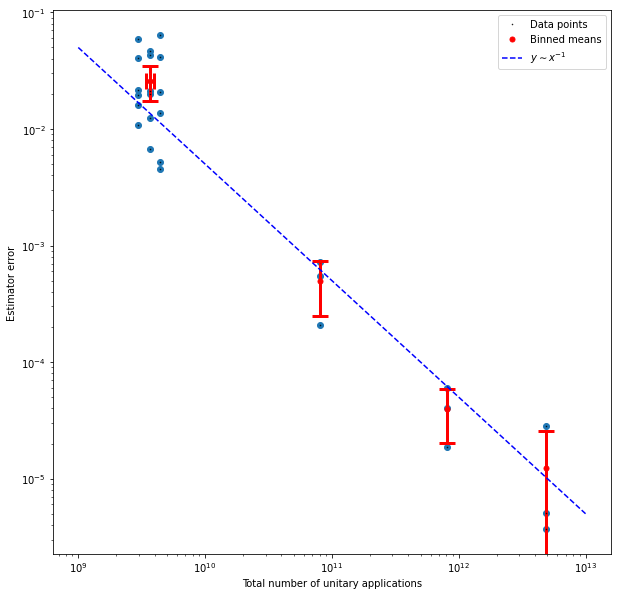

In [16]:
plt.figure(figsize = (10, 10))
#eaf.
plot_estimation_errors(costs, est_errors)
plt.scatter([c for c in costs], [e for e in est_errors])
plt.plot(np.linspace(1e9, 1e13), 5e7/np.linspace(1e9, 1e13), 'b--', label = r'$y \sim x^{-1}$')
plt.legend()
plt.show()

# Plotting

In [8]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import rcParams

rcParams['mathtext.fontset'] = 'custom'
rcParams['mathtext.rm'] = 'Bitstream Vera Sans'
rcParams['mathtext.it'] = 'Bitstream Vera Sans:italic'
rcParams['mathtext.bf'] = 'Bitstream Vera Sans:bold'


rcParams['mathtext.fontset'] = 'stix'
rcParams['font.family'] = 'STIXGeneral'

rcParams['font.sans-serif'] = 'Modern Roman'
rcParams['font.family'] = "serif"

rcParams['font.size'] = 16

def plot_estimation_errors(costs_big, est_errors_big, color, conf, rejection_multiplier=20):
    midpoints = np.sort(np.kron(10**np.arange(
        start = np.floor(np.log10(np.min([np.min(c) for c in costs_big]))),
        stop = 1+np.ceil(np.log10(np.max([np.max(c) for c in costs_big])))
    ), [1, 3]))
    log_midpoints = np.log(midpoints)
    log_edges = 0.5 * (log_midpoints[:-1] + log_midpoints[1:])
    edges = np.exp(log_edges)
    print(midpoints)
    print(edges)
    right_edge = max(edges)
    num_edges = len(edges)
    bin_xvals = [[] for x in midpoints]
    bin_yvals = [[] for x in midpoints]
    num_rejections = 0
    for costs, est_errors in zip(costs_big, est_errors_big):
        for cvec, errorvec in zip(costs, est_errors):
            for c, error in zip(cvec, errorvec):
#                 if error > 0.5:
#                     num_rejections += 1
#                     continue
                if c > right_edge:
                    bin_xvals[-1].append(c)
                    bin_yvals[-1].append(error)
                else:
                    index = min([j for j in range(num_edges) if edges[j] > c])
                    bin_xvals[index].append(c)
                    bin_yvals[index].append(error)
#     for bx, by in zip(bin_xvals, bin_yvals):
#         mean_by = np.mean(by)
#         std_error_by = np.std(by) / np.sqrt(len(by))
#         for j in range(len(bx)-1, -1, -1):
#             if abs(by[j]-mean_by) > rejection_multiplier * std_error_by or by[j] > 0.5:
#                 del by[j]
#                 del bx[j]
#                 num_rejections += 1
    print('Proportion of rejected samples: {}'.format(num_rejections / sum([len(b) for b in bin_xvals])))
    for n in range(num_edges, -1, -1):
        if len(bin_xvals[n]) == 0:
            del bin_xvals[n]
            del bin_yvals[n]
            
    binx_means = [np.mean(b) for b in bin_xvals]
    binx_err = [np.std(b) / np.sqrt(len(b)) * 2 for b in bin_xvals]
    biny_means = [np.mean(b) for b in bin_yvals]
    biny_max = [np.percentile(b, conf) for b in bin_yvals]
    biny_up = [bmax-bmean for bmax,bmean in zip(biny_max, biny_means)]
    biny_min  = [np.percentile(b, 100-conf) for b in bin_yvals]
    biny_down = [bmean-bmin for bmin,bmean in zip(biny_min, biny_means)]
    
    factor = np.exp(np.polyfit(np.zeros(len(binx_means)), np.log(binx_means)+np.log(biny_means), 0))
    print('Factor:',factor)
    
#     prev_ylims = plt.gca().get_ylim()
#     prev_xlims = plt.gca().get_xlim()
#     ymin = min(biny_min)
#     ymax = max(biny_max)
#     xmin = binx_means[0]-binx_err[0]
#     xmax = binx_means[-1]+binx_err[-1]
    
#     plt.hlines([ymin, ymax], xmin, xmax, color = color)
#     plt.vlines([xmin, xmax], ymin, ymax, color = color)
    
#     print(prev_ylims, ymin, ymax)
#     if(prev_ylims == (0,1)):
#         plt.ylim(ymin, ymax)
#     else:
#         plt.ylim(min(ymin, prev_ylims[0]), max(ymax, prev_ylims[1]))
#     print(prev_xlims, xmin, xmax)
#     if(prev_xlims == (0,1)):
#         plt.xlim(xmin, xmax)
#     else:
#         plt.xlim(min(xmin, prev_xlims[0]), max(xmax, prev_xlims[1]))
    
    
    plt.plot([x for b in bin_xvals for x in b], [y for b in bin_yvals for y in b],
             '.', markersize=1, color = color, alpha = 0.5)

    #plt.plot(binx_means, biny_means, 'r+', markersize=20, markeredgewidth=3)
    plt.plot(binx_means, biny_means, 'o', markersize=5, color = color)
    plt.errorbar(binx_means, biny_means, yerr=(biny_down, biny_up), xerr=binx_err, fmt='.',
                 color=color, capsize=8, capthick=2, linewidth=2)
    plt.xscale('log')
    plt.yscale('log')
    xvec_temp = np.linspace(min(binx_means)/1e1, max(binx_means)*1e1)
    plt.plot(xvec_temp, factor/xvec_temp, '--', color = 'k')
    #plt.plot(midpoints, 5000/midpoints, 'b--', label=r'$y\sim 1/x$')
    #plt.legend()#fontsize=22)
    plt.xlabel(r'Total quantum cost $T$')
    plt.ylabel(r'Estimator error $\delta$')
#plot_estimation_errors(costs_somma, errors_somma, color_somma, 80)

/home/teobrien/python_envs/standard_env_301020/lib/python3.8/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


/home/teobrien/python_envs/standard_env_301020/lib/python3.8/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


[1.e+09 3.e+09 1.e+10 3.e+10 1.e+11 3.e+11 1.e+12 3.e+12 1.e+13 3.e+13
 1.e+14 3.e+14 1.e+15 3.e+15 1.e+16 3.e+16 1.e+17 3.e+17 1.e+18 3.e+18]
[1.73205081e+09 5.47722558e+09 1.73205081e+10 5.47722558e+10
 1.73205081e+11 5.47722558e+11 1.73205081e+12 5.47722558e+12
 1.73205081e+13 5.47722558e+13 1.73205081e+14 5.47722558e+14
 1.73205081e+15 5.47722558e+15 1.73205081e+16 5.47722558e+16
 1.73205081e+17 5.47722558e+17 1.73205081e+18]
Proportion of rejected samples: 0.0
Factor: [2.18699135e+10]
[1.e+04 3.e+04 1.e+05 3.e+05 1.e+06 3.e+06 1.e+07 3.e+07 1.e+08 3.e+08
 1.e+09 3.e+09 1.e+10 3.e+10 1.e+11 3.e+11 1.e+12 3.e+12 1.e+13 3.e+13
 1.e+14 3.e+14]
[1.73205081e+04 5.47722558e+04 1.73205081e+05 5.47722558e+05
 1.73205081e+06 5.47722558e+06 1.73205081e+07 5.47722558e+07
 1.73205081e+08 5.47722558e+08 1.73205081e+09 5.47722558e+09
 1.73205081e+10 5.47722558e+10 1.73205081e+11 5.47722558e+11
 1.73205081e+12 5.47722558e+12 1.73205081e+13 5.47722558e+13
 1.73205081e+14]
Proportion of rejected sa

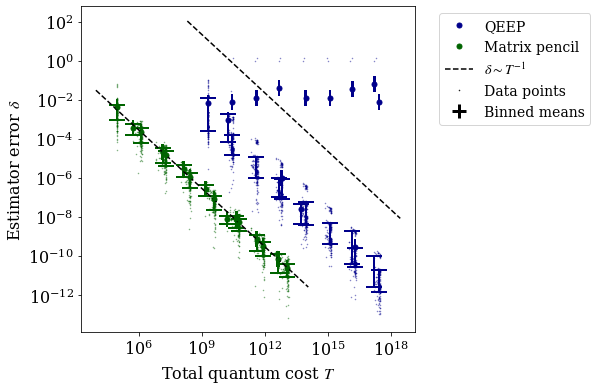

In [9]:
costs_somma = np.load('costs_qeep_multi_order_newest.npy', allow_pickle = True)
errors_somma = np.load('errors_qeep_multi_order_newest.npy', allow_pickle = True)
color_somma = 'darkblue'

# costs_somma_lc = np.load('costs_qeep_lowconfidence_multi_order_newest.npy', allow_pickle = True)
# errors_somma_lc = np.load('errors_qeep_lowconfidence_multi_order_newest.npy', allow_pickle = True)
# color_somma_lc = 'darkred'

costs_prony = np.load('costs_pencil_multi_order_newest.npy', allow_pickle = True)
errors_prony = np.load('errors_pencil_multi_order_newest.npy', allow_pickle = True)
color_prony = 'darkgreen'


plt.figure(figsize = (6, 6))
plot_estimation_errors(costs_somma, errors_somma, color_somma, 80)
#plot_estimation_errors(costs_somma_lc, errors_somma_lc, color_somma_lc, 80)
plot_estimation_errors(costs_prony, errors_prony, color_prony, 80)

plt.errorbar([],[],[], [], '.', color='black', capsize=3, capthick=3, linewidth = 3, label = 'Binned means')
plt.plot([],[], '.', color = color_somma, markersize = 10, label = r'QEEP')
# plt.plot([],[], '.', color = color_somma_lc, markersize = 10, label = r'QEEP low conf. ($34\%$ failed)')
plt.plot([],[], '.', color = color_prony, markersize = 10, label = r'Matrix pencil')
plt.plot([],[], '--', color = 'black', label = r'$\delta \sim T^{-1}$')
plt.plot([],[], '.', color = 'black', markersize = 1, label = r'Data points')

plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left', fontsize=14)

print(plt.gca().get_ylim())
#plt.xlim(1.5e5, 7e9)
#plt.ylim(1e-8, 0.8)
plt.savefig('error_vs_cost_plot_new.pdf',bbox_inches='tight')
plt.show()